# Analyze A/B Test Results 

I have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)

Specific programming tasks are marked with a **ToDo** tag. 

<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [45]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline


### ToDo 1.1
Now, I will read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>





**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [46]:
df= pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [47]:
"The number of rows of the dataset is {}, while the number of columns is {}".format(df.shape[0],df.shape[1])

'The number of rows of the dataset is 294478, while the number of columns is 5'

**c.** The number of unique users in the dataset.

In [48]:
unique_users= df['user_id'].nunique() #The number of all unique users in the dataset
unique_users

290584

**d.** The proportion of users converted.

In [49]:
unique_converted= df[df['converted'] == 1]['user_id'].nunique() #The number of all Unique USERS converted
proportion_users_converted= unique_converted/unique_users
proportion_users_converted

0.12104245244060237

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [50]:
#Checking for both cases of mismatch:
print(df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].count()[0]) 
print(df[(df['group'] == 'control') & (df['landing_page'] != 'old_page')].count()[0])

1965
1928


In [51]:
#Total number of mismatches
df[(df['group'] == 'treatment') & (df['landing_page'] != 'new_page')].count()[0] + df[(df['group'] == 'control') & (df['landing_page'] != 'old_page')].count()[0]

3893

**f.** Do any of the rows have missing values?

In [52]:
df.info() #checking null values 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [53]:
df[df.isnull().any(axis=1)] #making sure we have no missing values

,user_id,timestamp,group,landing_page,converted


### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


**a.** Now, we will create a new dataset, and Store it as new dataframe in **df2**.

In [54]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2= df.copy()

In [55]:
mistmatch_case1= df2[(df2['group'] == 'treatment') & (df2['landing_page'] != 'new_page')]
mistmatch_case2= df2[(df2['group'] == 'control') & (df2['landing_page'] != 'old_page')]

In [56]:
df2.shape

(294478, 5)

In [57]:
df2.drop(index=mistmatch_case1.index, inplace=True)

In [58]:
df2.drop(index=mistmatch_case2.index, inplace=True)

In [59]:
#checking that removed rows are equal to the number of mismatched cases
df.shape[0] - df2.shape[0] 

3893

In [60]:
#checking that we don't have any mismatched cases in our df2 (Both cases should be zero)
print(df2[(df2['group'] == 'treatment') & (df2['landing_page'] != 'new_page')].count()[0])
print(df2[(df2['group'] == 'control') & (df2['landing_page'] != 'old_page')].count()[0])

0
0


In [61]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Checking our dataset further...

**a.** How many unique **user_id**s are in **df2**?

In [62]:
unique_users_df2= df2['user_id'].nunique()
unique_users_df2

290584

**b.** Duplicated users?

In [63]:
duplicated_user_id= df2['user_id'].value_counts().idxmax()
duplicated_user_id

773192

**c.** Display the rows for the duplicate **user_id**? 

In [64]:
df2[df2['user_id'] == duplicated_user_id]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [65]:
# Remove one of the rows with a duplicate user_id..
df2.drop(index=df2[df2['user_id'] == duplicated_user_id].index[0],inplace=True)


In [66]:
# Check again if the row with a duplicate user_id is deleted or not 
df2[df2['user_id'] == duplicated_user_id]
#Now, we have only one row connected to this user_id

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


### ToDo 1.4  
Futher exploration...

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>


In [67]:
#The number of our population
population= df2['converted'].count()
population

290584

In [68]:
#The number of people converted, overall
total_converted= df2[df2['converted'] == 1].count()[0]
total_converted

34753

In [69]:
#Total conversion rate
total_conversion_rate= total_converted / population
total_conversion_rate

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [70]:
#The number of people in our control group
control_group= df2[df2['group'] == 'control'].count()[0]
control_group

145274

In [71]:
#The number of conversions in the control group
converted_control_group= df2[(df2['group'] == 'control') & (df2['converted'] == 1)].count()[0]
converted_control_group

17489

In [72]:
#Conversion Rate in the control group
conversion_rate_control_group= converted_control_group / control_group
conversion_rate_control_group

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [73]:
#The number of people in the treatment group
treatment_group =df2[df2['group'] == 'treatment'].count()[0]
treatment_group

145310

In [74]:
#Double checking that our two groups add up to the number of the population (This should return True)
control_group + treatment_group == population

True

In [75]:
#The number of people converted in the treatment group
converted_treatment_group = df2[(df2['group'] == 'treatment') & (df2['converted'] ==1)].count()[0]
converted_treatment_group 

17264

In [76]:
#Conversion Rate in the treatment group
conversion_rate_treatment_group= converted_treatment_group / treatment_group
conversion_rate_treatment_group

0.11880806551510564

>**Note**: The probabilities I've computed in the points (b). and (c). above can also be treated as conversion rate.   

In [77]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = conversion_rate_treatment_group - conversion_rate_control_group
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [78]:
new_page_prop= df2[df2['landing_page'] == 'new_page'].count()[0] / population
new_page_prop

0.50006194422266881

**e.** Let's consider the results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**Based on the results that we have so far, it seems that the conversion rate of the new page (0.1188) is NOT higher than the conversion rate of old page (0.1204), and it is below the overall conversion rate despite the landing page (0.1196).The observed difference between the conversion rate of the treatment group minus the conversion rate of the control group is negative (-0.0016), indicating that the new page is falling behind. However, the difference isn't that big.**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, We could run a hypothesis test continuously as long as we observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider we need to make the decision just based on all the data provided.  

> Recall that we just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be our null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

We can state our hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>$H_0$: $p_{new}$ - $p_{old}$ <= 0  
>$H_1$: $p_{new}$ - $p_{old}$ > 0

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, I will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Let's use the cells below to provide the necessary parts of this simulation.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [79]:
#It's equal to the overall conversion rate
total_conversion_rate

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [80]:
#It's equal to the overall conversion rate
total_conversion_rate

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*In orther words*: The treatment group users are shown the new page.

In [81]:
#calculated before
treatment_group

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [82]:
#calculated before
control_group

145274

In [83]:
#Creating a df with the treatment group
df_treatment= df2[df2['group'] == 'treatment']
df_treatment.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [84]:
#Creating a df with the control group
df_control= df2[df2['group'] == 'control']
df_control.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
5,936923,2017-01-10 15:20:49.083499,control,old_page,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0


**e. Simulate Sample for the `treatment` Group**<br> 

Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

*Note*: We can use `numpy.random.choice()` method to randomly generate $n_{new}$ number of values. <br>

Store these $n_{new}$ 1's and 0's in the `new_page_converted` numpy array.


In [85]:
# Simulate a Sample for the treatment Group
new_page_converted= np.random.choice(df_treatment['converted'],size=treatment_group)
new_page_converted

array([0, 0, 0, ..., 1, 0, 0])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [86]:
# Simulate a Sample for the control Group
old_page_converted= np.random.choice(df_control['converted'], size= control_group)
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for our simulated samples from the parts (e) and (f) above. 

In [87]:
new_page_converted.mean() - old_page_converted.mean()

0.0010507649925542012


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process we used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

In [88]:
# Sampling distribution 
p_diffs = []
for num in range(10000):
    new_page_converted= np.random.choice(df_treatment['converted'],size=treatment_group)
    old_page_converted= np.random.choice(df_control['converted'], size= control_group)
    means_diff= new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(means_diff)
    
p_diffs = np.array(p_diffs)

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  

Also, I will use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  


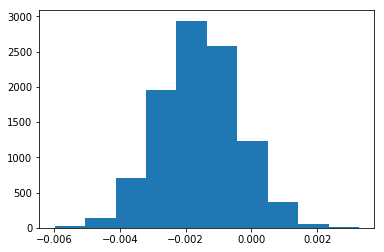

In [89]:
plt.hist(p_diffs);
#The graph is a normal distribution, which is expected thanks to the sampling distribution

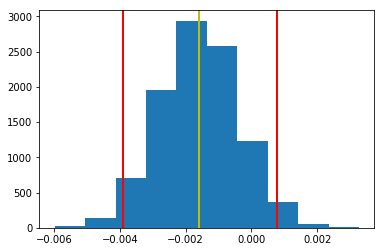

In [90]:
#Getting the confidence interval of 95%
np.percentile(p_diffs, 2.5), np.percentile(p_diffs, 97.5)
plt.hist(p_diffs);
plt.axvline(np.percentile(p_diffs, 2.5), color='r',linewidth=2); 
plt.axvline(np.percentile(p_diffs, 97.5), color='r',linewidth=2);
plt.axvline(obs_diff, color='y',linewidth=2); #the observed diff in the mean

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [136]:
#Getting the P_value
null_diff= 0 #The value of the difference in the means under the null hypothesis
null_vals= np.random.normal(null_diff, p_diffs.std(),10000)

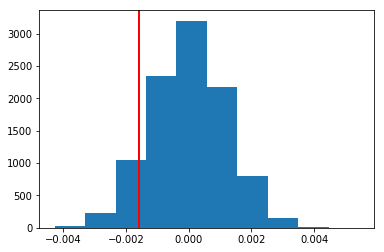

In [137]:
plt.hist(null_vals);
plt.axvline(obs_diff, color='r', linewidth= 2);

In [138]:
#Calculating the P_value
(null_vals>obs_diff).mean()

0.90549999999999997

In [139]:
#The p_value is much higher than 0.05 

**k.** Let's explain in words what we have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

>**The Value that we calculated is called the P_value, and it's about testing whether the result that we got is from this distribution or from another distribution. In other words, it is testing whether we got our results by the element of chance or no.**

> **The higher the P_value, the more we fail to reject the null hypothesis, and the opposite is true. The lower the P_value, the more we move towards rejecting the null hypothesis in favor of the alternative hypothesis.**

> **We chose to have a Type 1 error rate of 0.05 (5%), and our P_value is 0.905 (90.5%). Then, we fail to reject the null hypothesis, which means that statistically we couldn't find enough proof to say that the new page will perform better than the old page in terms of conversion rates.**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Let's Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [95]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = converted_control_group

# number of conversions with the new_page
convert_new = converted_treatment_group

# number of individuals who were shown the old_page
n_old = control_group

# number of individuals who received new_page
n_new = treatment_group

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**m.** Now Let's use `sm.stats.proportions_ztest()` to compute our test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Note**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that we have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for our two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. We can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

We also need to decide if our hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

>Note:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---

In [96]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([converted_treatment_group,converted_control_group],[treatment_group,control_group],alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


**n.** What do the z-score and p-value we computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>


>**The Z-test score means that we are (-1.3109) standard deviations away from the mean of the distribution, and the P_value score is telling us how likely we can get the observed value from this distribution, and not from another one.**

>**Generally, a Z-test score less than 2 standard deviations away from the center of the distribution is considered NOT statisically significant, which was also confirmed by the p_value.**

>**As we can see the findings from the Z-test and using statsmodels to calculate the P_Value agree with our previous results.**

>**We see that the P_Value from both tests are similar (0.905, and 0.905). Based on that, we fail to reject the null hypothesis as we can't see enough evidence that the new page will generate more conversions.**

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should we be performing in this case?

>**We should perform Logistic Regression as what we test can either be True or False**

**b.** The goal is to use **statsmodels** library to fit the regression model we specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, we first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [97]:
df2['intercept'] = 1

In [98]:
df2['ab_page']= pd.get_dummies(df2['landing_page']).iloc[:,0]
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate our regression model on the two columns we created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [99]:
logit_m= sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results= logit_m.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of our model below, and use it as necessary to answer the following questions.

In [100]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-09-29 12:09 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [142]:
# Getting the exponent of the (ab_page) so that we can interpert the findings better
np.exp(-0.0150)

0.98511193960306265

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value we found in **Part II**?<br><br>  



>**The p_value associated with ab_page is (0.1899) in the summary of the logistic regression.**

>**It's different from the p_value that we got from part 2 because logistic regressions calculate the odds ratio, which is the likelyhood of one value actually occurring, not the response itself; based on that, the null hypothesis of a logistic regression is that "there is no correlation between the variables", and then it tests that, then the p_value of the logistic regression is telling us whether this test is statistically significant or no.**

**f.** Now, we are considering other things that might influence whether or not an individual converts.  Let's discuss why it is a good idea to consider other factors to add into our regression model.  Are there any disadvantages to adding additional terms into our regression model?

>**Thinking about other factors to add to our regression model is generally a good thing especially if a domain expert is consulted to validate which elements might be essential to add in the regression mode (example: talking to a doctor about which might be important to add in predecting a certain disease).**

>**In our case, we might consider other elements to add, like: the country of the user, the device the user is using, the time of the day, month, or year, etc. However, we need to remember our main question and hypothesis and then decide whether adding these elements to our model are going to be helpful or not.**

>**Another problem we might face when we add a lot of elements is "overfitting" especially if we are trying to use or model to predict against unseen data because the model will perform very well in the case of train data but not other wise.**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. We will need to read in the **countries.csv** dataset and merge together our `df2` datasets on the appropriate rows. We call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 
>**Note:** I will use `pandas.get_dummies()` to create dummy variables. **I will utilize two columns for the three dummy variables.** 


In [143]:
# Read the countries.csv
df_countries= pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [144]:
# Join with the df2 dataframe 
df_merged= df2.set_index('user_id').join(df_countries.set_index('user_id'))
df_merged.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [145]:
# Create the necessary dummy variables
df_merged[['UK','US']]= pd.get_dummies(df_merged['country'],drop_first=True)

In [146]:
#Removing unnecessary categorical data columns after creating the dummy variables for our regression model
df_merged= df_merged.drop(['group','country','landing_page'], axis=1)

In [147]:
df_merged.head()

,timestamp,converted,intercept,ab_page,UK,US
user_id,,,,,,
851104,2017-01-21 22:11:48.556739,0,1,0,0,1
804228,2017-01-12 08:01:45.159739,0,1,0,0,1
661590,2017-01-11 16:55:06.154213,0,1,1,0,1
853541,2017-01-08 18:28:03.143765,0,1,1,0,1
864975,2017-01-21 01:52:26.210827,1,1,0,0,1


In [161]:
logit_mod= sm.Logit(df_merged['converted'], df_merged[['intercept','ab_page','UK','US']])
results= logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-09-29 12:35 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

In [162]:
#exponentiate ab_page
np.exp(-0.0149)

0.9852104557227469

In [149]:
# Getting the exponent of the (UK) so that we can interpert the findings better
np.exp(0.0507)

1.0520072437650141

In [158]:
# Getting the exponent of the (US) so that we can interpert the findings better
np.exp(0.0408)

1.0416437559600236

**Observation:**
>*From what we saw, it seems that adding countries to the model isn't statistically significant as a predictor.*

>*The individual is (1.05, and 1.04) more likely to convert if they come from the UK and US respectively, compared to Canada holding all other variables.*

>*Looking at the P_value in the summary, we can see that these findings aren't statistaclly significant.*

**h. Fit our model and obtain the results**<br> 
Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **We will create the necessary additional columns, and fit the new model.** 


I will provide the summary results (statistical output), and my conclusions (written response) based on the results. 


In [168]:
#adding an interaction term between the page and the country (ab_page*UK)
df_merged['ab_page*UK']= df_merged['ab_page'] * df_merged['UK']

In [171]:
#adding an interaction term between the page and the country (ab_page*US)

df_merged['ab_page*US']= df_merged['ab_page'] * df_merged['US']

In [172]:
df_merged.head()

,timestamp,converted,intercept,ab_page,UK,US,ab_page*UK,ab_page*US
user_id,,,,,,,,
851104,2017-01-21 22:11:48.556739,0,1,0,0,1,0,0
804228,2017-01-12 08:01:45.159739,0,1,0,0,1,0,0
661590,2017-01-11 16:55:06.154213,0,1,1,0,1,0,1
853541,2017-01-08 18:28:03.143765,0,1,1,0,1,0,1
864975,2017-01-21 01:52:26.210827,1,1,0,0,1,0,0


In [173]:
# Fit our model, and summarize the results
logit_mod= sm.Logit(df_merged['converted'], df_merged[['intercept','ab_page','UK','US', 'ab_page*UK','ab_page*US']])
results= logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-09-29 12:52 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
ab_page*UK     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
ab_page*US     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

>**Based on the results, we can see that the results are NOT statistically significant in any of the following tests:
(ab_page, UK, US, ab_page * UK, ab_page * US) as the P_value of each of them is higher than 0.05 (our Type 1 error margin)**

>**Hence, we can say that:**
>>*It seems that the "new page" isn't generating more conversions.*
>>*We can't see a statistical significance of the country of residence, based on the provided countries, on the conversion rates.*

>**Based on theses findings, we fail to reject our null hypothesis**

In [177]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0